# Importación de librerías

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from src.video_processing_functions import *
from src.quality_measure_functions import *
from src.utility_functions import *

# Experimentos para el algoritmo *Frequency Domain Image Blur Measure* (FM)

## Medición sobre todo el frame

A continuación se presenta un experimento para medir el tiempo de ejecución del algoritmo FM sobre todo el frame. Utilizaremos el video [focus_video.mov](resources/focus_video.mov) para la experimentación. 

In [2]:
# Define the path to the video
video_path = 'resources/focus_video.mov'

La función `detect_max_focus_points` recibe el path del video y retorna una lista con todas las medidas de FM para cada frame, una lista con los puntos de mayor enfoque y el máximo enfoque alcanzado.

In [3]:
quality_measurements_list, max_focus_points, max_focus_value = detect_max_focus_points(video_path)

Se extraeran los frames de mayor enfoque y se utilizarán en la función `plot_focus_measurement_versus_frame` para graficar la evolución de la métrica frame a frame. 

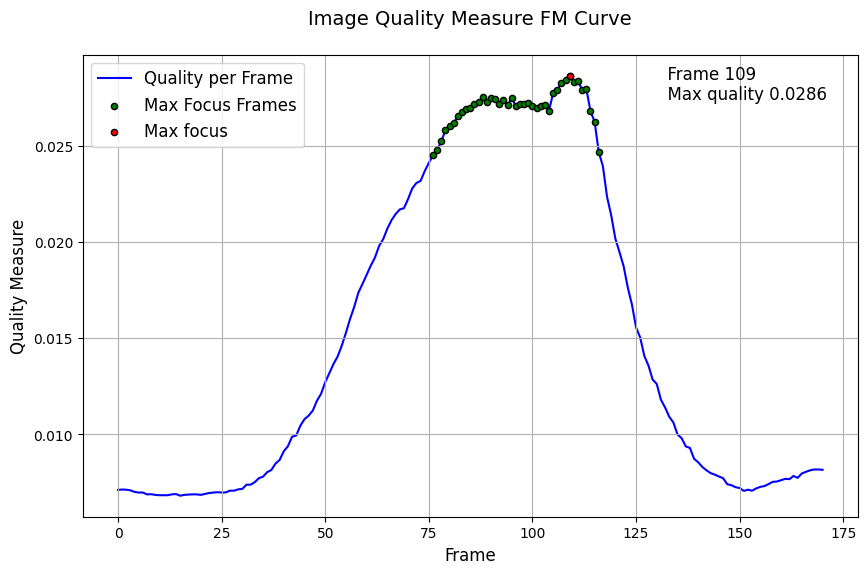

In [4]:
max_focus_frames = [value[0] for value in max_focus_points]
plot_focus_measurement_versus_frame(quality_measurements_list, max_focus_frames, max_focus_value)

In [5]:
print('Max focus points:', max_focus_frames)

Max focus points: [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116]


Como se puede ver en la gráfica superior, la calidad de la imagen es variable a lo largo del video. Los frames de buen enfoque comienzan a partir del frame 76 y se extienden hasta el frame 116. Se alcanza el **punto de máxima calidad de 0.0286 en el frame 109**.

A continuación se presenta un video donde se visualiza un recuadro sobre el frame completo, que se pinta de color verde cuando el frame es de buena calidad y de color rojo cuando el frame es de mala calidad. Para ello se utiliza la función `display_video_highlight_max_focus` que recibe el path del video, la lista de los puntos de mayor enfoque y la lista completa de las medidas de enfoque.

In [6]:
display_video_highlight_max_focus(
    video_path = video_path, 
    max_focus_points = max_focus_points, 
    quality_measurements_list = quality_measurements_list,
)

En el video se puede visualizar el mismo comportamiento que en la gráfica, donde los frames de buena calidad se encuentran entre los frames 76 y 116.

## Medición sobre una ROI ubicada en el centro de la imagen

Área de la ROI de 5 o 10% del tamaño de la imagen original.

---

A continuación se experimenta con una región de interés (ROI) del 5% del tamaño de la imagen original.

In [7]:
roi_percentage = 0.05

quality_measurements_list, max_focus_points, max_focus_value = detect_max_focus_points(
    video_path = video_path, 
    roi_percentage = roi_percentage
)

Se extraen los frames de mayor enfoque y se utilizan en la función `plot_focus_measurement_versus_frame` para graficar la evolución de la métrica frame a frame.

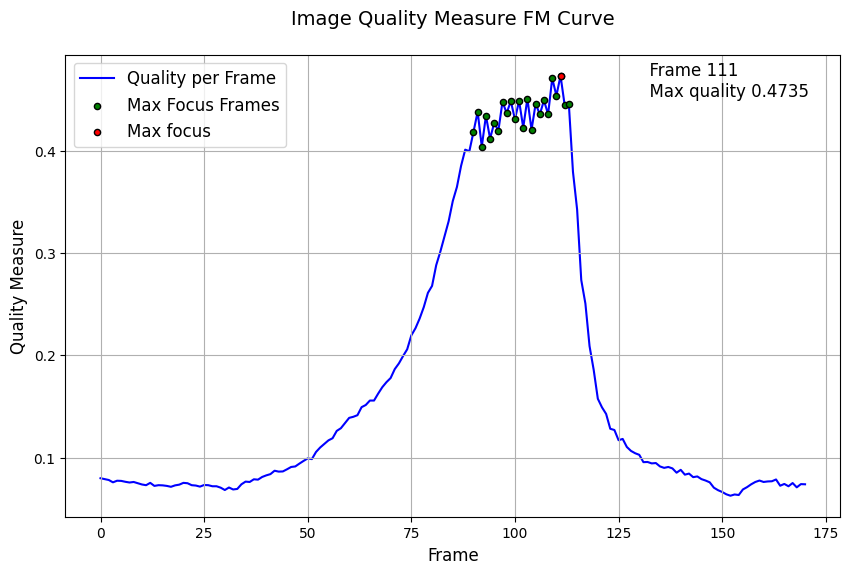

In [8]:
max_focus_frames = [value[0] for value in max_focus_points]
plot_focus_measurement_versus_frame(quality_measurements_list, max_focus_frames, max_focus_value)

Podemos ver en la imagen superior que la calidad de la imagen es variable a lo largo del video. La calidad alcanza un buen enfoque a partir del frame 90 y se extiende hasta el frame 113. Se alcanza un **punto de máxima calidad de 0.4735 en el frame 111**. Nótese que la calidad de la imagen en la ROI es mayor que la calidad de la imagen completa, pero se alcanzan valores de calidad considerados altos unos frames después.

In [9]:
print('Max focus points:', max_focus_frames)

Max focus points: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]


In [25]:
display_video_highlight_max_focus(
    video_path = video_path, 
    roi_percentage = roi_percentage,
    max_focus_points = max_focus_points, 
    quality_measurements_list = quality_measurements_list,    
)

En el video se puede visualizar el mismo comportamiento que en la gráfica, donde los frames de buena calidad se encuentran entre los frames 90 y 113. Además, se puede observar la ROI en el centro de la imagen, que se pinta de color verde cuando el frame es de buena calidad y de color rojo cuando el frame es de mala calidad.

Ahora se experimenta con una región de interés (ROI) del 10% del tamaño de la imagen original.

In [10]:
roi_percentage = 0.1

quality_measurements_list, max_focus_points, max_focus_value = detect_max_focus_points(
    video_path = video_path, 
    roi_percentage = roi_percentage
)

Se extraen los frames de mayor enfoque y se utilizan en la función `plot_focus_measurement_versus_frame` para graficar la evolución de la métrica frame a frame.

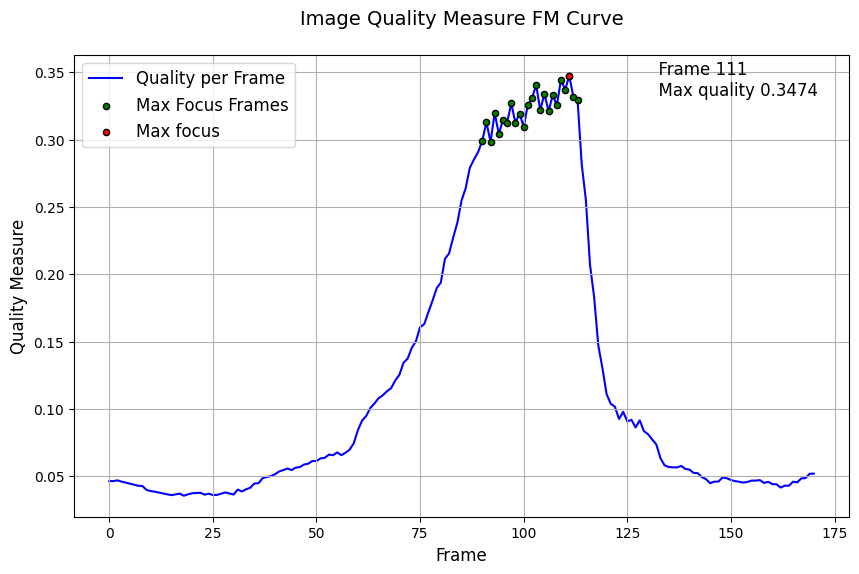

In [11]:
max_focus_frames = [value[0] for value in max_focus_points]
plot_focus_measurement_versus_frame(quality_measurements_list, max_focus_frames, max_focus_value)

In [12]:
print('Max focus points:', max_focus_frames)

Max focus points: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]


Podemos ver en la imagen superior que el frame donde se alcanza la máxima calidad es el mismo que en el caso anterior, es decir, el frame 111. La calidad de la imagen sin embargo es menor que en el caso anterior. Esto puede deberse a que la ROI es más grande y por lo tanto analiza más información de la imagen. Por otro lado, el rango de frames de buena calidad es el mismo que en el caso anterior, es decir, entre los frames 90 y 113.

In [29]:
display_video_highlight_max_focus(
    video_path = video_path, 
    roi_percentage = roi_percentage,
    max_focus_points = max_focus_points, 
    quality_measurements_list = quality_measurements_list,    
)

Igualmente, en el video se puede visualizar el mismo comportamiento que en la gráfica, donde la única diferencia es que la ROI es más grande y los valores de calidad son menores en comparación con el caso anterior.

## Medición sobre una matriz de enfoque

Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores 
arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

----

Para este experimento, la función [detect_max_focus_points](src/video_processing_functions.py) el tamaño de la ROI y el tamaño de la matriz de enfoque. En la función se computa una matríz de enfoque compuesta por un arreglo de $N \times M$ elementos rectangulares equiespaciados y se calcula la calidad de la imagen considerando el promedio de la calidad de cada elemento de la matriz, para obtener un valor de calidad correspondiente al frame.

In [13]:
N = 3
M = 3
roi_percentage = 0.2

quality_measurements_list, max_focus_points, max_focus_value = detect_max_focus_points(
    video_path = video_path, 
    N = N, 
    M = M, 
    roi_percentage = roi_percentage
)

Al dividir cada frame en una cuadrícula de $𝑁 \times M$ elementos rectangulares, se obtiene una medida de enfoque para cada sección, permitiendo detectar variaciones locales que podrían perderse en una evaluación global. Promediar estas medidas ofrece una representación precisa de la calidad de enfoque del frame completo, suavizando las fluctuaciones locales. En comparación con métodos que evalúan el frame completo o subregiones fijas, el enfoque de cuadrículas proporciona una mejor adaptabilidad y precisión.

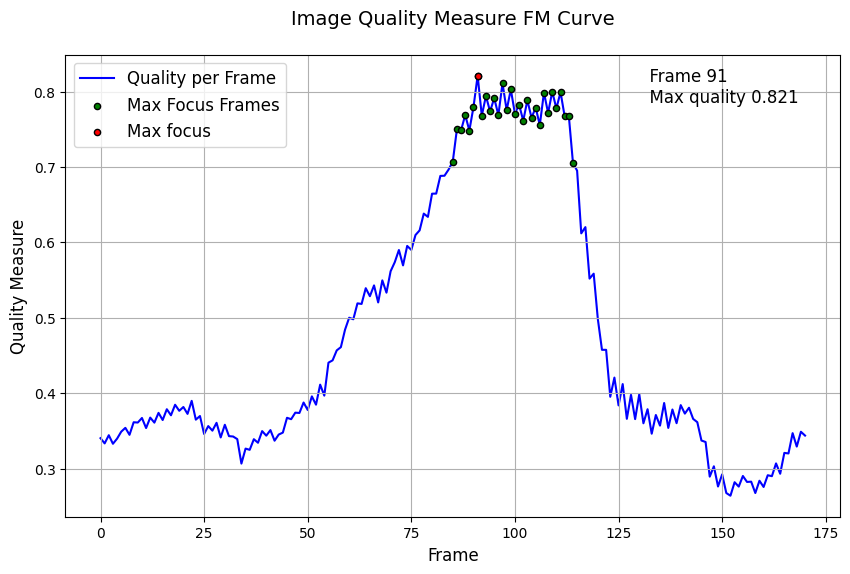

In [14]:
max_focus_frames = [value[0] for value in max_focus_points]
plot_focus_measurement_versus_frame(quality_measurements_list, max_focus_frames, max_focus_value)

In [15]:
print('Max focus points:', max_focus_frames)

Max focus points: [85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]


En la imagen superior se muestra la calidad de la imagen en función del frame para una matriz de enfoque de 3x3. Se puede observar que la calidad sigue una tendencia similar a las experimentaciones anteriores. Sin embargo, **se alcanza un punto de máxima calidad mayor, en este caso de 0.8210 en el frame 91**. Esto puede deberse a que la matriz de enfoque permite detectar variaciones locales que podrían perderse en una evaluación global de la imagen completa. Los puntos de enfoque de buena calidad comienzan en el frame 85 y se extienden hasta el frame 114.

In [33]:
display_video_highlight_max_focus(
    video_path = video_path, 
    M = N,
    N = M,
    roi_percentage = roi_percentage,
    max_focus_points = max_focus_points, 
    quality_measurements_list = quality_measurements_list,    
)

En la visualización del video se puede observar el mismo comportamiento que en la gráfica, donde los frames de buena calidad se encuentran entre los frames 85 y 114. Además, se puede observar la matriz de enfoque en el centro de la imagen, que se pinta de color verde cuando el frame es de buena calidad y de color rojo cuando el frame es de mala calidad.

A continuación, se experimenta con cuatro matrices de enfoque de tamaños 5x3, 7x5, 5x5, 7x7.

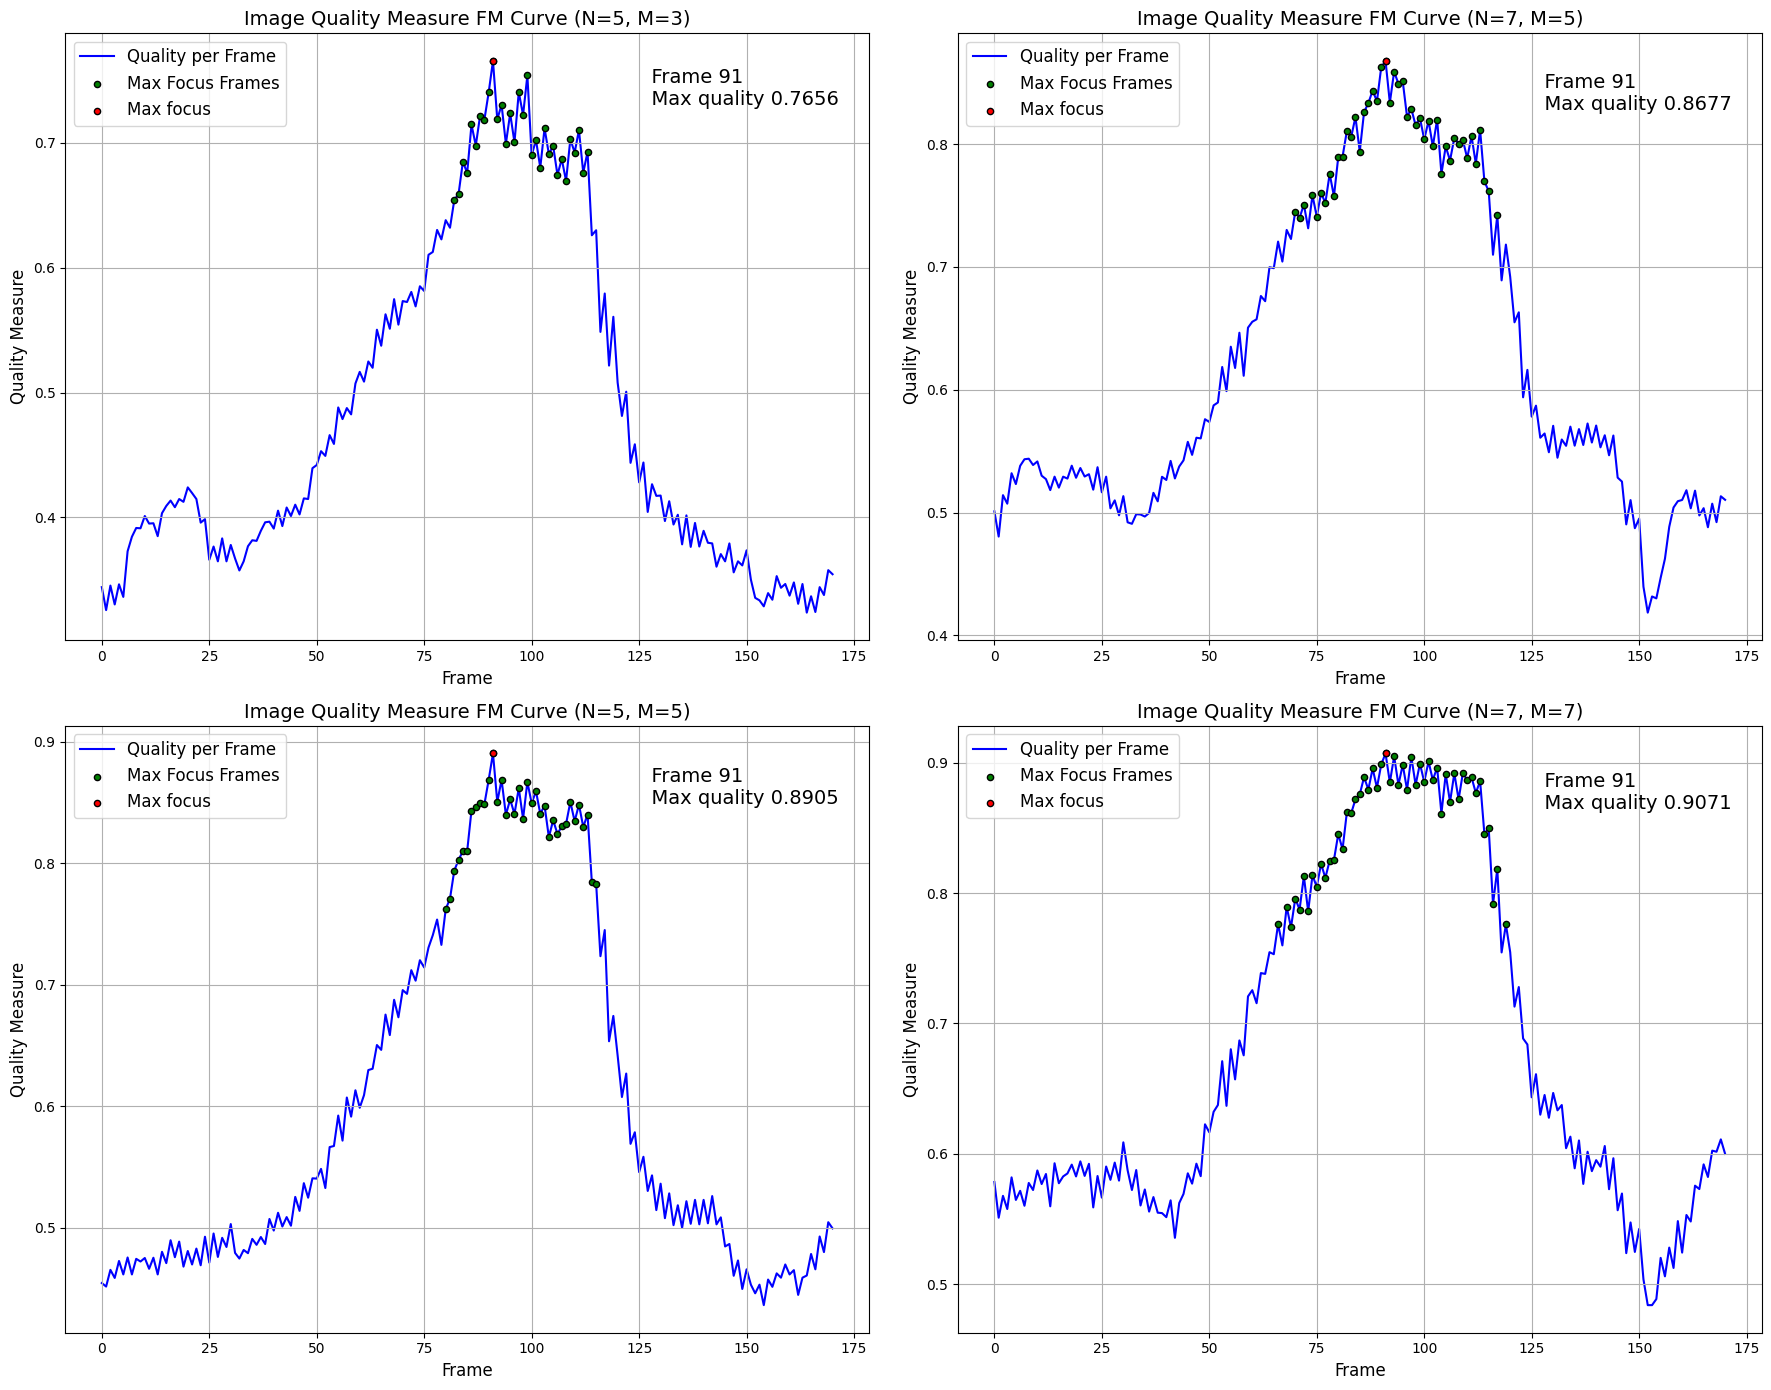

In [4]:
variations = [
    {'N': 5, 'M': 3, 'roi_percentage': 0.2},
    {'N': 7, 'M': 5, 'roi_percentage': 0.2},
    {'N': 5, 'M': 5, 'roi_percentage': 0.2},
    {'N': 7, 'M': 7, 'roi_percentage': 0.2}
]

plot_quality_measurements_on_2x2_grid(variations, video_path)

En las cuatro imágenes superiores se pueden experimentos ejecutados con cuatro diferentes matrices de enfoque. Se puede observar que la calidad de la imagen mantiene una tendencia similar a las experimentaciones anteriores. Igualmente, **el punto de máxima calidad se alcanza en el frame 91**. Sin embargo, se puede observar que la calidad de la imagen es mayor en las matrices de enfoque con mayor cantidad de elementos. 

Algo a notar es que **la matríz 7x7 alcanza una calidad de 0.9071**, manteniendo valores considerados de buen enfoque en un rango de frames mayor a los experimentos anteriores. 

In [5]:
show_video_highlight_with_variations(variations, video_path)

Ejecutando la función `show_video_highlight_with_variations` se pueden visualizar diferentes videos para diferenes matrices de enfoque. En los videos se puede observar el mismo comportamiento que en las gráficas. De manera solamente visual, se puede observar que las matrices de enfoque más grandes funcionan mejor.

# Experimentos utilizando el algoritmo Variance of Laplacian (LAP4)

Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure 
operators in shapefrom focus.

A continuación se presenta la experimentación con el algoritmo Variance of Laplacian (LAP4), implementado en la función `quality_measure_function` en el archivo [quality_measure_functions.py](src/quality_measure_functions.py).

## Medición sobre todo el frame

In [5]:
quality_measurements_list, max_focus_points, max_focus_value = detect_max_focus_points(video_path=video_path, quality_measure_function=variance_of_laplacian)

Se extraeran los frames de mayor enfoque y se utilizarán en la función `plot_focus_measurement_versus_frame` para graficar la evolución de la métrica frame a frame. 

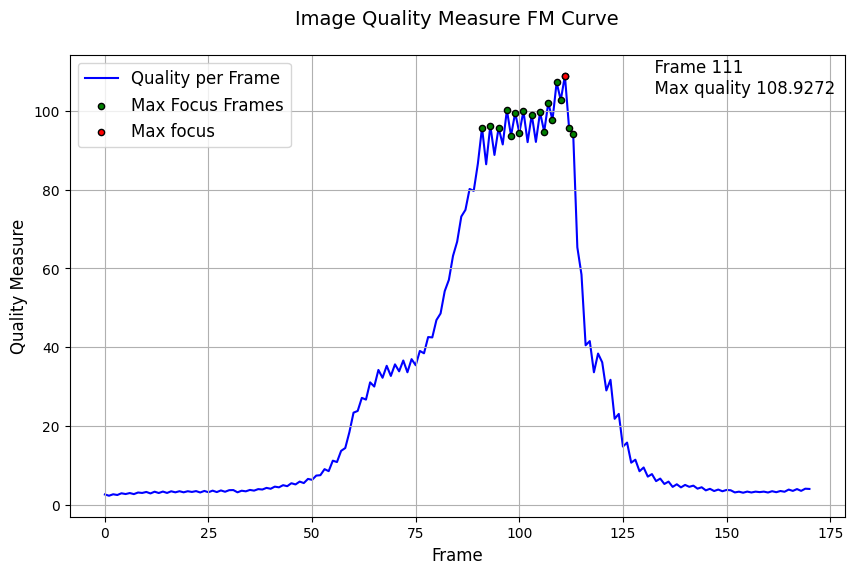

In [6]:
max_focus_frames = [value[0] for value in max_focus_points]
plot_focus_measurement_versus_frame(quality_measurements_list, max_focus_frames, max_focus_value)

In [7]:
print('Max focus points:', max_focus_frames)

Max focus points: [91, 93, 95, 97, 98, 99, 100, 101, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113]


Como se puede ver en la gráfica superior, al igual que con el algorítmo anterior, la calidad de la imagen es variable a lo largo del video. Los frames de buen enfoque comienzan a partir del frame 91 y se extienden hasta el frame 113. Se alcanza el **punto de máxima calidad de 108.9772 en el frame 111**.

Es interesante notar que la gráfica obtenida es muy similar a la obtenida con el algoritmo FM, pero considerando la ROI de 5% del tamaño de la imagen original.

In [9]:
display_video_highlight_max_focus(
    video_path = video_path, 
    max_focus_points = max_focus_points, 
    quality_measurements_list = quality_measurements_list,
)

En el video se puede visualizar el mismo comportamiento que en la gráfica, donde los frames de buena calidad se encuentran entre los frames 91 y 113. Nótese que hay un momento donde se detecta una pérdida de enfoque, esto puede deberse a que el algoritmo LAP4 es sensible al ruido en la imagen.

## Medición sobre una ROI ubicada en el centro de la imagen

Área de la ROI de 5 o 10% del tamaño de la imagen original.

---

A continuación se experimenta con una región de interés (ROI) del 5% del tamaño de la imagen original.

In [10]:
roi_percentage = 0.05

quality_measurements_list, max_focus_points, max_focus_value = detect_max_focus_points(
    video_path = video_path, 
    roi_percentage = roi_percentage,
    quality_measure_function=variance_of_laplacian
)

Se extraen los frames de mayor enfoque y se utilizan en la función `plot_focus_measurement_versus_frame` para graficar la evolución de la métrica frame a frame.

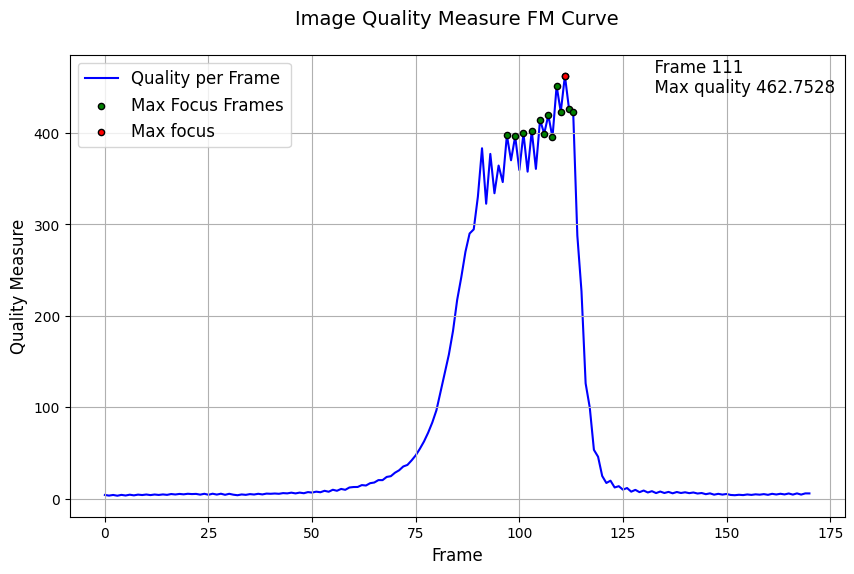

In [11]:
max_focus_frames = [value[0] for value in max_focus_points]
plot_focus_measurement_versus_frame(quality_measurements_list, max_focus_frames, max_focus_value)

In [12]:
print('Max focus points:', max_focus_frames)

Max focus points: [97, 99, 101, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113]


Podemos ver en la imagen superior que la calidad de la imagen es variable a lo largo del video. La calidad alcanza un buen enfoque a partir del frame 97 y se extiende hasta el frame 113. Se alcanza un **punto de máxima calidad de 462.7528 en el frame 111**. Nótese que al igual que con el algoritmo FM, la calidad de la imagen en la ROI es mayor que la calidad de la imagen completa.

In [14]:
display_video_highlight_max_focus(
    video_path = video_path, 
    roi_percentage = roi_percentage,
    max_focus_points = max_focus_points, 
    quality_measurements_list = quality_measurements_list,    
)

En el video se puede visualizar el mismo comportamiento que en la gráfica, donde los frames de buena calidad se encuentran entre los frames 97 y 113. Donde resalta que el rango de valores considerados de buen enfoque es mucho menor que su contraparte con el algoritmo FM.

Ahora se experimenta con una región de interés (ROI) del 10% del tamaño de la imagen original.

In [15]:
roi_percentage = 0.1

quality_measurements_list, max_focus_points, max_focus_value = detect_max_focus_points(
    video_path = video_path, 
    roi_percentage = roi_percentage,
    quality_measure_function=variance_of_laplacian
)

Se extraen los frames de mayor enfoque y se utilizan en la función `plot_focus_measurement_versus_frame` para graficar la evolución de la métrica frame a frame.

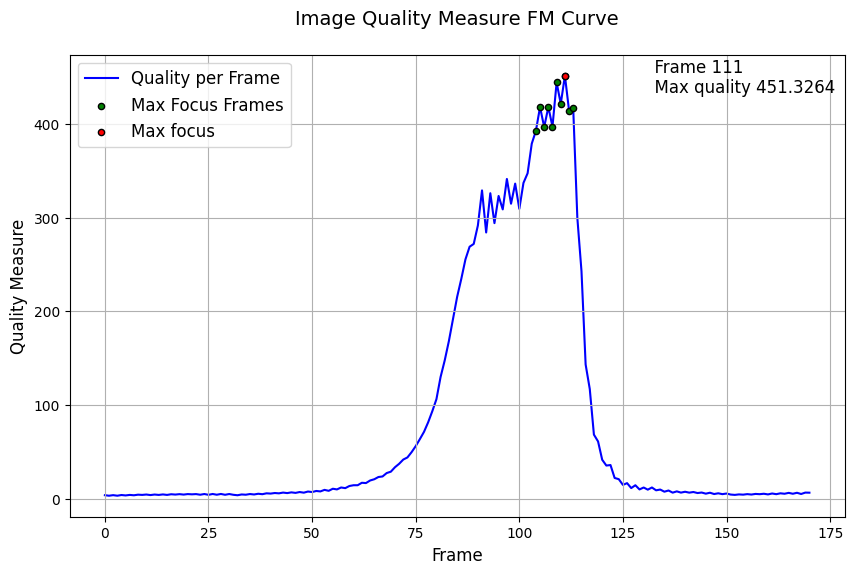

In [16]:
max_focus_frames = [value[0] for value in max_focus_points]
plot_focus_measurement_versus_frame(quality_measurements_list, max_focus_frames, max_focus_value)

In [17]:
print('Max focus points:', max_focus_frames)

Max focus points: [104, 105, 106, 107, 108, 109, 110, 111, 112, 113]


Podemos ver en la imagen superior que el frame donde se alcanza la máxima calidad es el mismo que en el caso anterior, es decir, el frame 111. Sin embargo, el rango de frames de buena calidad es menor que en el caso anterior, entre los frames 104 y 113, y mucho menor que su contraparte con el algoritmo FM. Por otro lado, no existen saltos de buena calidad a mala calidad, como ocurría en los casos anteriores. Una vez que se detecta buen enfoque, se mantiene a lo largo del rango.

In [19]:
display_video_highlight_max_focus(
    video_path = video_path, 
    roi_percentage = roi_percentage,
    max_focus_points = max_focus_points, 
    quality_measurements_list = quality_measurements_list,    
)

Igualmente, en el video se puede visualizar el mismo comportamiento que en la gráfica, donde la única diferencia es que la ROI es más grande.

## Medición sobre una matriz de enfoque

Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores 
arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

----

Para este experimento, la función [detect_max_focus_points](src/video_processing_functions.py) el tamaño de la ROI y el tamaño de la matriz de enfoque. En la función se computa una matríz de enfoque compuesta por un arreglo de $N \times M$ elementos rectangulares equiespaciados y se calcula la calidad de la imagen considerando el promedio de la calidad de cada elemento de la matriz, para obtener un valor de calidad correspondiente al frame.

In [3]:
N = 3
M = 3
roi_percentage = 0.2

quality_measurements_list, max_focus_points, max_focus_value = detect_max_focus_points(
    video_path = video_path, 
    N = N, 
    M = M, 
    roi_percentage = roi_percentage,
    quality_measure_function=variance_of_laplacian
)

Al dividir cada frame en una cuadrícula de $𝑁 \times M$ elementos rectangulares, se obtiene una medida de enfoque para cada sección, permitiendo detectar variaciones locales que podrían perderse en una evaluación global. Promediar estas medidas ofrece una representación precisa de la calidad de enfoque del frame completo, suavizando las fluctuaciones locales. En comparación con métodos que evalúan el frame completo o subregiones fijas, el enfoque de cuadrículas proporciona una mejor adaptabilidad y precisión.

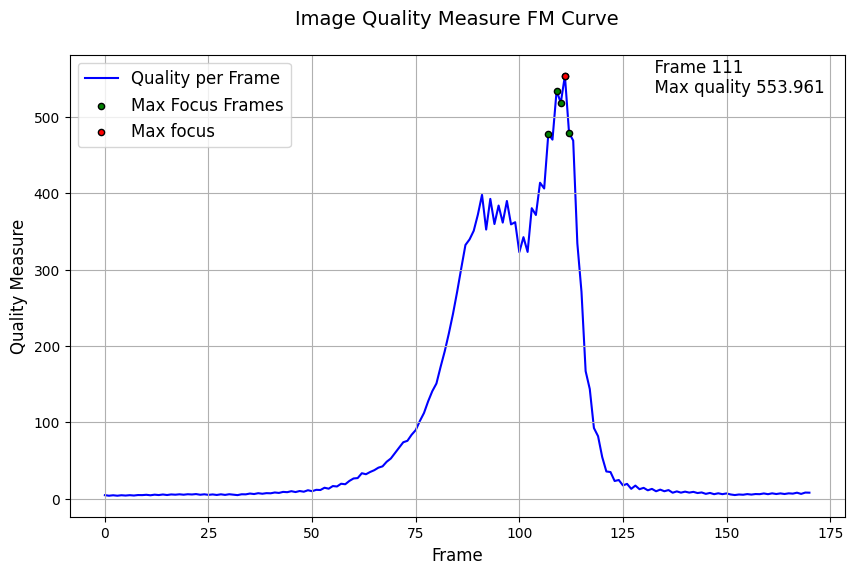

In [4]:
max_focus_frames = [value[0] for value in max_focus_points]
plot_focus_measurement_versus_frame(quality_measurements_list, max_focus_frames, max_focus_value)

In [5]:
print('Max focus points:', max_focus_frames)

Max focus points: [107, 109, 110, 111, 112]


En la imagen superior se muestra la calidad de la imagen en función del frame para una matriz de enfoque de 3x3. En este caso se puede observar que el rango de frames de buena calidad es menor que en los experimentos anteriores, entre los frames 107 y 112. Sin embargo, **el punto de máxima calidad se alcanza en el frame 111**, al igual que en todos los experimentos realizados con LAP4.

In [8]:
display_video_highlight_max_focus(
    video_path = video_path, 
    M = N,
    N = M,
    roi_percentage = roi_percentage,
    max_focus_points = max_focus_points, 
    quality_measurements_list = quality_measurements_list,    
)

En la visualización del video se puede observar el mismo comportamiento que en la gráfica, notando que el rango de frames de buena calidad es menor que en los experimentos anteriores.

A continuación, se experimenta con cuatro matrices de enfoque de tamaños 5x3, 7x5, 5x5, 7x7.

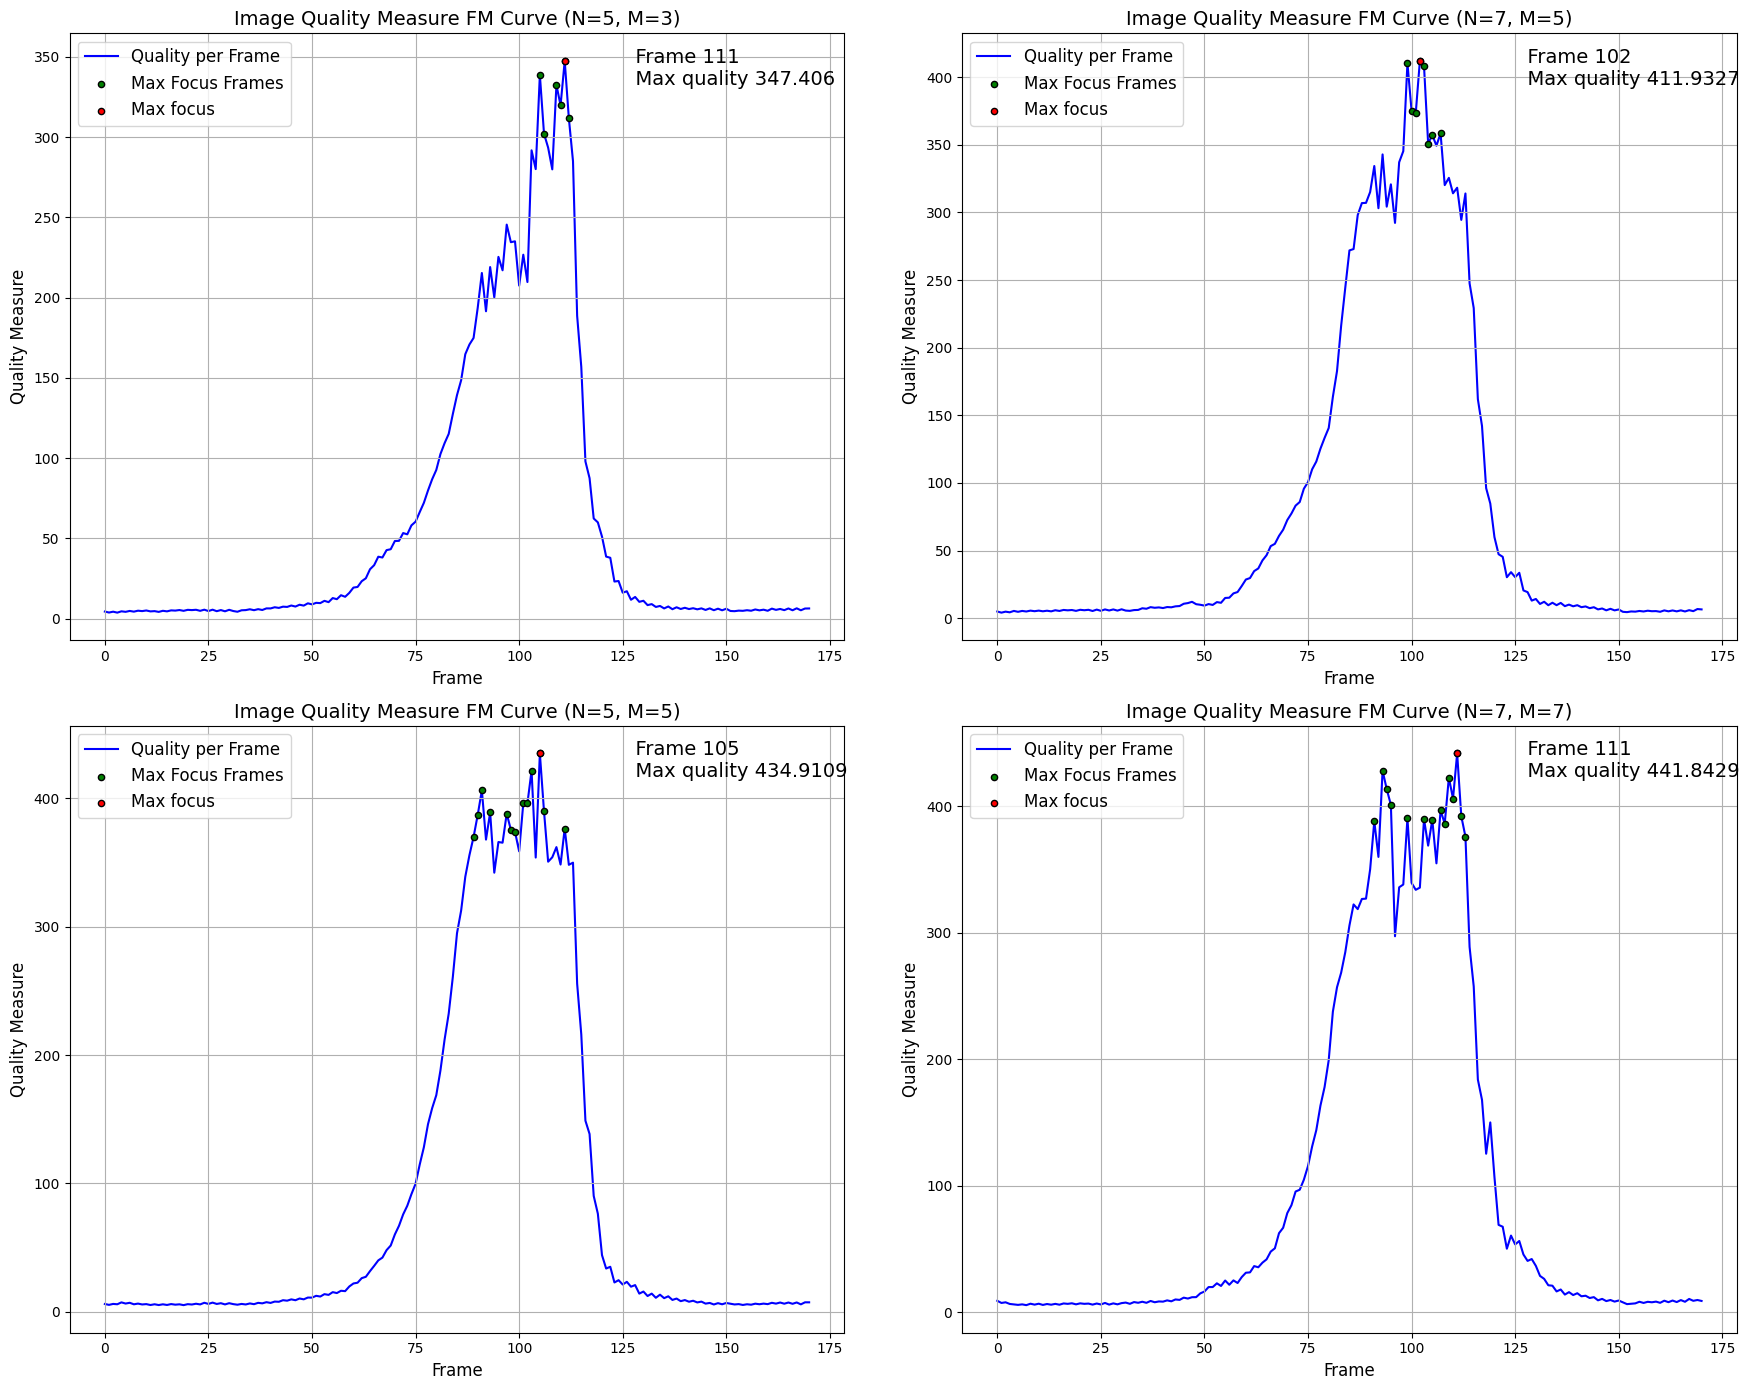

In [6]:
variations = [
    {'N': 5, 'M': 3, 'roi_percentage': 0.2},
    {'N': 7, 'M': 5, 'roi_percentage': 0.2},
    {'N': 5, 'M': 5, 'roi_percentage': 0.2},
    {'N': 7, 'M': 7, 'roi_percentage': 0.2}
]

plot_quality_measurements_on_2x2_grid(variations, video_path, quality_measure_function=variance_of_laplacian)

En las cuatro imágenes superiores se pueden experimentos ejecutados con cuatro diferentes matrices de enfoque. Se puede observar que la calidad de la imagen mantiene una tendencia similar al experimento anterior, teniendo un rango de frames de buena calidad mucho más reducido. También notese en este caso que de los cuatro experimentos, solo dos concuerdan en que **el punto de máxima calidad se alcanza en el frame 111**. 

In [7]:
show_video_highlight_with_variations(variations, video_path, quality_measure_function=variance_of_laplacian)

Ejecutando la función `show_video_highlight_with_variations` se pueden visualizar diferentes videos para diferenes matrices de enfoque. En los videos se puede observar el mismo comportamiento que en las gráficas. En este caso, se puede observar que las matrices de enfoque más grandes tienen rangos de frames de buena calidad más amplios.